# Image segmentation using traditonal machine learning

In [49]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Get an example image and its labeled counterpart (ground truth)

We need to use a labeled image as ground truth. We can produce such a image by painting the relevant regions using Fiji, or other segmentation algorithms to automate the process (easier if you have only two classes).

Shapes: Original --> (512, 512)  Labeled -->  (512, 512)


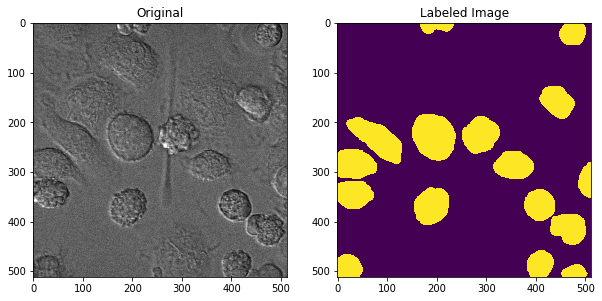

In [50]:
# import the images, both original and ground truth.
img = cv2.imread('images/apoptosis/original.tif')
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
labeled_img = cv2.imread('images/apoptosis/label.tif')
labeled_img_grayscale = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(img_grayscale, cmap='gray')
plt.title('Original')

fig.add_subplot(1,2,2)
plt.imshow(labeled_img_grayscale) 
plt.title('Labeled Image')

print('Shapes: Original -->',img_grayscale.shape, ' Labeled --> ', labeled_img_grayscale.shape)

### Step 2: Create feature bank

A feature bank is just a DataFrame containing the values of the pixels from the original image as a column along with many filtered versions of the image as sepaarte columns. The last column will be the label.

#### Create the DataFrame and fill it with mutiple filters features

In [51]:
df = pd.DataFrame()
img_col = img_grayscale.reshape(-1)

#### ORIGINAL PIXELS

In [52]:
df['Original_pixels'] = img_col

#### GABOR FEATURES

In [53]:
#parameters (allow to generate a large set of features)

ksize = 5 #depends on the feature size you want to enhance | Hardcoded here.
phi = 0 #offset | Hardcoded here

gabor_index = 0
gabor_kernels = []

for theta in range(2):
    theta = theta /4. * np.pi
    for sigma in (3,5):
        for lambd in np.arange(0, np.pi, np.pi /4.):
            for gamma in (0.05, 0.5):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
                gabor_kernels.append(kernel)
                filtered_img = cv2.filter2D(img_grayscale, cv2.CV_8UC3, kernel)
                filtered_img_col = filtered_img.reshape(-1)
                df[f'Gabor_{gabor_index}'] = filtered_img_col
                gabor_index += 1
 

#### CANNY FEATURES (edge detector)

In [54]:
canny_min = np.arange(50,200,20)
canny_max = np.arange(50,200,20)

for min in canny_min:
    for max in canny_max:
        img_edges = cv2.Canny(img_grayscale, min, max)
        img_edges_col = img_edges.reshape(-1)
        df[f'Canny_{min}_{max}'] = img_edges_col

#### ROBERTS, SOBEL, SCHARR, PREWITT FEATURES

In [55]:
from skimage.filters import roberts, sobel, scharr, prewitt

img_roberts = roberts(img_grayscale)
df['Roberts'] = img_roberts.reshape(-1)

img_sobel = sobel(img_grayscale)
df['Sobel'] = img_sobel.reshape(-1)

img_scharr = scharr(img_grayscale)
df['Scharr'] = img_scharr.reshape(-1)

img_prewitt = prewitt(img_grayscale)
df['Prewitt'] = img_prewitt.reshape(-1)

#### GAUSSIAN

In [56]:
from scipy import ndimage as nd

for gauss_sigma in np.arange(1,20,2):
    gaussian_img = nd.gaussian_filter(img_grayscale, gauss_sigma)
    df[f'Gaussian_{gauss_sigma}'] = gaussian_img.reshape(-1)

#### VARIANCE (SLOW !)

In [57]:
#for variance_size in np.arange(1,5,1):
#    variance_img = nd.generic_filter(img_grayscale, np.var, size=variance_size)
#    df[f'Variance_{variance_size}'] = variance_img.reshape(-1)

#### MEDIAN

In [58]:
for median_size in np.arange(1,10,2):
    median_img = nd.median_filter(img_grayscale, size=median_size)
    df[f'Median_{median_size}'] = median_img.reshape(-1)

#### Print the feature stack to see how it looks like                

In [59]:
df.head(10)

,Original_pixels,Gabor_0,Gabor_1,Gabor_2,Gabor_3,Gabor_4,Gabor_5,Gabor_6,Gabor_7,Gabor_8,...,Gaussian_11,Gaussian_13,Gaussian_15,Gaussian_17,Gaussian_19,Median_1,Median_3,Median_5,Median_7,Median_9
0,54,0,0,0,0,0,0,0,0,0,...,94,95,95,96,96,54,60,88,88,91
1,92,0,0,0,0,0,0,255,247,0,...,94,95,96,96,96,92,92,87,92,92
2,100,0,0,0,0,0,0,55,55,0,...,94,95,96,96,96,100,98,96,96,92
3,98,0,0,0,0,0,0,111,107,0,...,95,95,96,96,96,98,98,98,97,95
4,97,0,0,0,0,0,0,114,113,0,...,95,95,96,96,96,97,98,99,98,97
5,99,0,0,0,0,0,0,139,133,0,...,95,95,96,96,96,99,99,99,99,97
6,100,0,0,0,0,0,0,94,93,0,...,95,95,96,96,96,100,99,99,99,99
7,95,0,0,0,0,0,0,162,157,0,...,95,95,96,96,96,95,97,99,101,101
8,94,0,0,0,0,0,0,119,116,0,...,96,96,96,96,96,94,95,101,101,101
9,94,0,0,0,0,0,0,113,111,0,...,96,96,96,96,97,94,97,101,102,101


#### Add labels

In [60]:
df['Labels'] = labeled_img_grayscale.reshape(-1)
df.head(10)

,Original_pixels,Gabor_0,Gabor_1,Gabor_2,Gabor_3,Gabor_4,Gabor_5,Gabor_6,Gabor_7,Gabor_8,...,Gaussian_13,Gaussian_15,Gaussian_17,Gaussian_19,Median_1,Median_3,Median_5,Median_7,Median_9,Labels
0,54,0,0,0,0,0,0,0,0,0,...,95,95,96,96,54,60,88,88,91,0
1,92,0,0,0,0,0,0,255,247,0,...,95,96,96,96,92,92,87,92,92,0
2,100,0,0,0,0,0,0,55,55,0,...,95,96,96,96,100,98,96,96,92,0
3,98,0,0,0,0,0,0,111,107,0,...,95,96,96,96,98,98,98,97,95,0
4,97,0,0,0,0,0,0,114,113,0,...,95,96,96,96,97,98,99,98,97,0
5,99,0,0,0,0,0,0,139,133,0,...,95,96,96,96,99,99,99,99,97,0
6,100,0,0,0,0,0,0,94,93,0,...,95,96,96,96,100,99,99,99,99,0
7,95,0,0,0,0,0,0,162,157,0,...,95,96,96,96,95,97,99,101,101,0
8,94,0,0,0,0,0,0,119,116,0,...,96,96,96,96,94,95,101,101,101,0
9,94,0,0,0,0,0,0,113,111,0,...,96,96,96,97,94,97,101,102,101,0


### Step 3: Create the model and validate it

#### We need to split the dataset into test and training sets

The **independant** variable is `Labels`, and usually noted **X**. Everything else is **a dependant variable**, noted **Y** such as in *Y=f(X)*, where *f* is the model.

In [61]:
Y = df['Labels'].values
X = df.drop(labels = 'Labels', axis=1)#keepe everythin but the column 'Labels'

#Split the data in test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.4, random_state=20) #60% train data, 40% test

#### Implement the model and fit it

This is the actual machine learning part.

In [62]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, random_state=42) #see doc for explanations

model.fit(X_train, Y_train);

#### Do a prediction from the test data and calculate the accuracy of the model

In [63]:
prediction_test = model.predict(X_test)

from sklearn import metrics
print('Accuracy = ', metrics.accuracy_score(Y_test, prediction_test)) #compare predicitons with test data

Accuracy =  0.8780159835205706


### Step 4: Find which features are relevant

We use `model.feature_importances` to check what feature contributes the most to the prediction

In [64]:
# There's a built-in function to get the feature importances:
# importances = list(model.feature_importances_) 

#Make it pretty using features list as column indexes
features_list = list(X.columns) # create a list of features from the independant variables

feature_importances = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print('Feature importances (contribution in percent): \n')
print(feature_importances.head(20))

Feature importances (contribution in percent): 

Gaussian_5         0.051412
Gaussian_11        0.050035
Scharr             0.048678
Prewitt            0.043642
Median_3           0.040599
Gaussian_17        0.039590
Gaussian_9         0.038651
Median_9           0.036972
Sobel              0.034785
Gaussian_7         0.033941
Gaussian_15        0.033308
Gaussian_19        0.032233
Roberts            0.029308
Gaussian_13        0.029256
Gaussian_1         0.028274
Median_5           0.027301
Median_7           0.026411
Gaussian_3         0.024948
Median_1           0.022834
Original_pixels    0.021843
dtype: float64


From these values, we could now restrict the feature creation to only the **top 10 features listed** to save computer time.

### Step 5: Save the model as pickle and reuse it

If we are satisfied with the model, we can save it in the *pickle* format.

In [65]:
import pickle

filename = 'cilia_model_random_forest'
pickle.dump(model, open(filename, 'wb')) #save it in write mode (w) and in binary (b)

#### Reusing the model and show comparison with the ground truth image

In [66]:
loaded_model = pickle.load(open(filename, 'rb')) #opens a file in read (r) binary (b) mode

new_prediction = loaded_model.predict(X)

Text(0.5, 1.0, 'Segmented Image with ML')

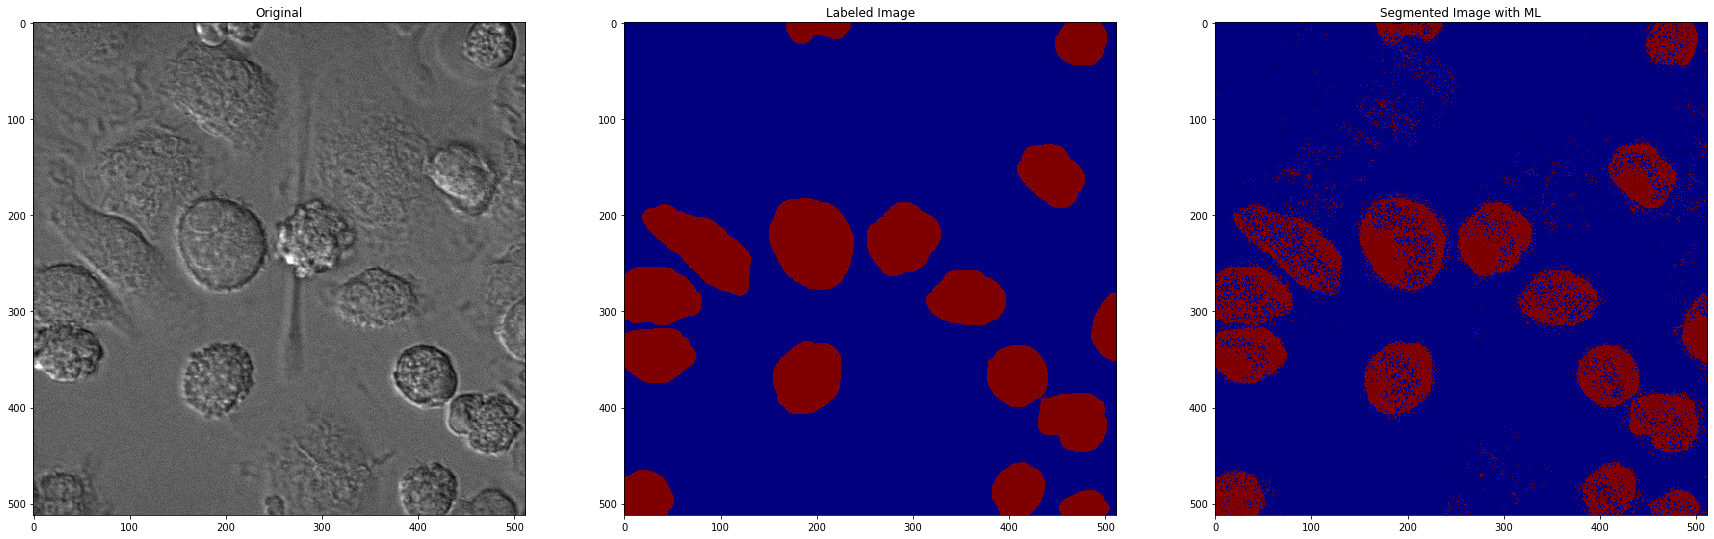

In [67]:
segmented_img = new_prediction.reshape((img_grayscale.shape))

fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,3,1)
plt.imshow(img_grayscale, cmap='gray')
plt.title('Original')

fig.add_subplot(1,3,2)
plt.imshow(labeled_img_grayscale, cmap='jet') 
plt.title('Labeled Image')

fig.add_subplot(1,3,3)
plt.imshow(segmented_img, cmap='jet') 
plt.title('Segmented Image with ML')

### Step 6: Use the model for batch segmentation